# Importação de bibliotecas


In [16]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from gensim.models.coherencemodel import CoherenceModel

# Baixar recursos do NLTK


In [17]:
# Baixar recursos do NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/aluno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/aluno/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/aluno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/aluno/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Base de dados


In [18]:
# Carregar o dataset
dataSetIfg = pd.read_csv('centro-oeste.csv')

# Exibir as primeiras linhas para verificar se a leitura foi correta
dataSetIfg.head()

,text
Especialização gratuita em Docência do IFMS abre 70 vagas https://t. co/jpYhozmVWG,Especialização gratuita em Docência do IFMS ab...
Não ironicamente eu gosto mais do ifb do que qualquer outra escola que eu tenha estudado,Não ironicamente eu gosto mais do ifb do que q...
saudade almoço do ifb,saudade almoço do ifb
O Instituto oferece reforço escolar com disciplinar militar além de atividades esportivas e de musicalização para crianças e adolescentes. Conta com a parceria das Forças Armadas da UFMS e do IFMS e apoio de empresários. Agora está reivindicando também apoio do poder público.,O Instituto oferece reforço escolar com disci...
Estiver hoje dia 07 / 07 como Representante Geral dos Estudantes do IFB e Militante do PT na inauguração do Centro de Formação Tecnológica (CFT) do Instituto Federal de Brasília no IFB Campus Estrutural que contou com a participação da Reitora Luciana do IFB e do Diretor Geral. https://t. co/Os7JCsWUKy,Estiver hoje dia 07 / 07 como Representante Ge...


# Limpeza dos dados 


In [19]:
def clean_text(text):
    if isinstance(text, str):  # Verifica se é uma string
        # Remove URLs completas e truncadas
        text = re.sub(r'https?://\S+\.\.\.|https?://\S+', '', text, flags=re.MULTILINE)
        # Remove URLs que começam com "www"
        text = re.sub(r'www\.\S+', '', text)
        # Remove hashtags
        text = re.sub(r'#\S+', '', text)
        # Remove menções
        text = re.sub(r'@\S+', '', text)
        # Remove números
        text = re.sub(r'\d+', '', text)
        # Remove pontuações e caracteres especiais
        text = re.sub(r'[^\w\s]', '', text)
        # Remove stop words
        stop_words = set(stopwords.words('portuguese'))
        # Tokeniza o texto (divide em palavras)
        words = text.split()
        # Filtra as stop words
        filtered_words = [word for word in words if word.lower() not in stop_words]
        # Junta as palavras de volta em um texto
        text = ' '.join(filtered_words)
        return text.strip()  # Remove espaços extras no início e no final
    return text  # Retorna o texto original se não for uma string
    
# Função para remover palavras ofensivas
def remove_offensive_words(text, offensive_words):
    if isinstance(text, str):  # Verifica se é uma string
        words = text.split()  # Divide o texto em palavras
        cleaned_words = [word for word in words if word.lower() not in offensive_words]
        return ' '.join(cleaned_words)
    return text  # Retorna o texto original se não for uma string


# Lista de palavras ofensivas
offensive_words = ['vtnc', 'qm', 'matar', 'sim', 'pqp', 'porra', 'puta', 'pariu', 'foda', 'cu', 'matar', 'pqp', 'porra', 'desgraca', 'desgraça', 'puto', 'foder', 'vsf', 'puta', 'caralho']

# Aplicar as funções no dataset
dataSetIfg['text'] = dataSetIfg['text'].apply(clean_text)
dataSetIfg['Message_Cleaned'] = dataSetIfg['text'].apply(lambda x: remove_offensive_words(x, offensive_words))

# Remover pontuação e converter para minúsculas
dataSetIfg['text_processed'] = dataSetIfg['Message_Cleaned'].map(
    lambda x: re.sub('[,\.!?]', '', x) if isinstance(x, str) else x
)
dataSetIfg['text_processed'] = dataSetIfg['text_processed'].map(
    lambda x: x.lower() if isinstance(x, str) else x
)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    return ' '.join(tokens)

dataSetIfg['text_processed'] = dataSetIfg['text'].apply(preprocess_text)

# Exibir as primeiras linhas do resultado
dataSetIfg['text_processed'].head()

Especialização gratuita em Docência do IFMS abre 70 vagas https://t. co/jpYhozmVWG                                                                                                                                                                                                                                   especialização gratuita docência ifms abre vag...
Não ironicamente eu gosto mais do ifb do que qualquer outra escola que eu tenha estudado                                                                                                                                                                                                                             ironicamente gosto ifb qualquer outra escola e...
saudade almoço do ifb                                                                                                                                                                                                                                                                     

# Frequencia de palavras


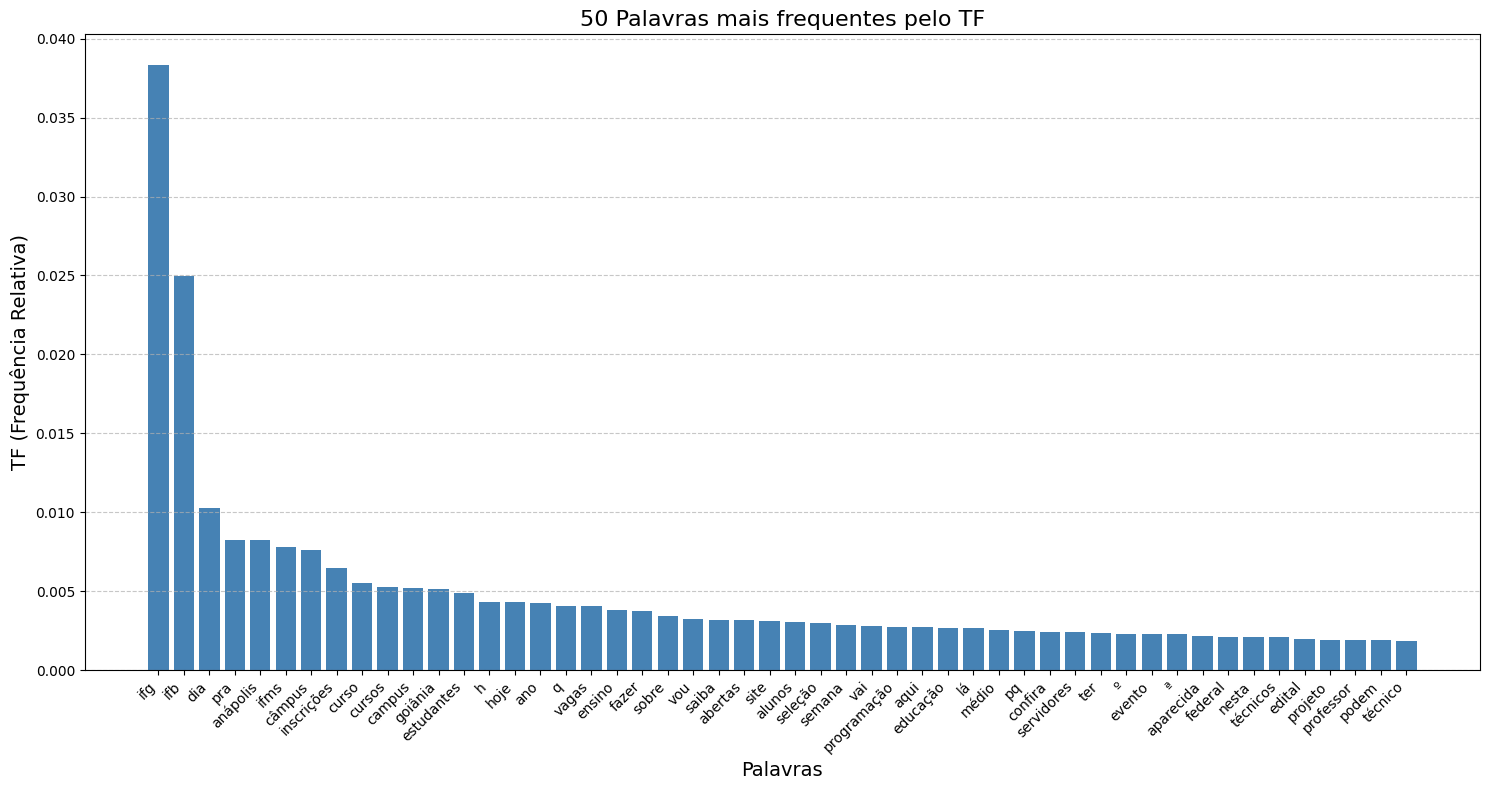

In [20]:
# Separar todas as palavras
all_words = []
for message in dataSetIfg['text_processed']:
    if isinstance(message, str):  # Verifica se o valor é uma string
        all_words.extend(message.split())  # Divide o texto em palavras e adiciona à lista

# Calcular a frequência total das palavras (TF)
total_words = len(all_words)
word_counts = Counter(all_words)
tf = {word: count / total_words for word, count in word_counts.items()}

# Ordenar palavras pelo TF em ordem decrescente e pegar as 50 mais frequentes
sorted_tf = sorted(tf.items(), key=lambda x: x[1], reverse=True)[:50]

# Separar palavras e valores de TF
words = [item[0] for item in sorted_tf]
tf_values = [item[1] for item in sorted_tf]

# Gerar histograma das palavras mais frequentes pelo TF
plt.figure(figsize=(15, 8))
plt.bar(words, tf_values, color='steelblue')
plt.xlabel('Palavras', fontsize=14)
plt.ylabel('TF (Frequência Relativa)', fontsize=14)
plt.title('50 Palavras mais frequentes pelo TF', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Remoção de stop words


In [21]:
import re

# Lista de stop words personalizada
stop_words = stopwords.words('portuguese')
stop_words.extend([  'cosnwsqvzqs', 'cocuzwjicwjf', 'cozwwqdvnbp', 'cosnnohoj', 'cojbgfeupwk', 'corkrzqxb',
    'excuse', 'dont', 'maybes', 'absolute', 'ands', 'yes', 'or', 'exception', 'same', 'butt',
    'we', 'you', 'more', 'embarrassing', 'self', 'made', 'taxon', 'beep', 'kamenrider', 'cn'
    'sim', 'ok', 'bom', 'cn', 'sei', 'co', 'qm', 'mlk', 'vi', 'bo', 'nada', 'sdd', 'sdds', 'bora',
    'ngc', 'fumou', 'md', 'vc', 'vcs', 'do', 'no', 'msm', 'de', 'e', 'a', 'eu', 'que', 'o', 'é', 
    'da', 'em', 'na', 'não', 'pra', 'um', 'com', 'q', 'me', 'uma', 'se', 'mais', 'os', 'para',
    'meu', 'minha', 'as', 'só', 'vou', 'buts', 'mas', 'tem', 'por', 'dia', 'foi', 'vai', 'como', 
    'fazer', 'pq', 'ifal', 'ter', 'ano', 'já', 'ser', 'esse', 'dos', 'isso', 'n', 'quando', 'muito', 
    'até', 'essa', 'tá', 'era', 'ifam', 'tô', 'ele', '-', 'hoje', 'hj', 'lá', 'vc', 'nem', 'nao', 
    'ainda', 'to', 'ifsp', 'ela', 'todo', 'ifce', 'das', 'tenho', 'ou', 'tava', 'tudo', 'aqui', 'assim', 
    'são', 'anos', 'agora', 'ver', 'ir', 'sem', 'nunca', 'tinha', 'quem'])

# Função para remover stop words e palavras com "kk"
def remove_stopwords_and_kk(text):
    # Remove stop words
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    
    # Remove tudo a partir de "kk"
    text = re.sub(r'\bkk\b.*', '', text)
    
    return text.strip()

# Aplicar a remoção de stop words e palavras com "kk"
dataSetIfg['text_processed'] = dataSetIfg['text_processed'].apply(remove_stopwords_and_kk)

# Exibir as primeiras linhas após remoção de stop words e palavras com "kk"
dataSetIfg['text_processed'].head()

Especialização gratuita em Docência do IFMS abre 70 vagas https://t. co/jpYhozmVWG                                                                                                                                                                                                                                   especialização gratuita docência ifms abre vag...
Não ironicamente eu gosto mais do ifb do que qualquer outra escola que eu tenha estudado                                                                                                                                                                                                                             ironicamente gosto ifb qualquer outra escola e...
saudade almoço do ifb                                                                                                                                                                                                                                                                     

In [22]:
def remove_short_words(text, min_length=3):
    return ' '.join([word for word in text.split() if len(word) >= min_length])

dataSetIfg['text_processed'] = dataSetIfg['text_processed'].apply(remove_short_words)

# BERTopic 


In [23]:
# Pré-processamento para BERTopic
data = dataSetIfg.text_processed.values.tolist()
data_words = [simple_preprocess(text, deacc=True) for text in data]

# Remover stop words novamente (garantia)
data_words = [[word for word in doc if word not in stop_words] for doc in data_words]

# Criar dicionário e corpus
id2word = Dictionary(data_words)
corpus = [id2word.doc2bow(doc) for doc in data_words]

# Visualizar o corpus
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [24]:
# Inicializar o BERTopic
embedding_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

#umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
#hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', prediction_data=True)
#vectorizer_model = CountVectorizer(stop_words=stop_words)
#ctfidf_model = ClassTfidfTransformer()


In [25]:
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  #umap_model=umap_model,              # Step 2 - Reduce dimensionality
  #hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  #vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  #ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
  nr_topics=50
)

In [26]:
# Ajustar o modelo
topics, _ = topic_model.fit_transform(data)


In [27]:
# Visualizar os tópicos
#print(topic_model.get_topic_info())

In [28]:
# Visualizar a hierarquia de tópicos
topic_model.visualize_hierarchy()

In [31]:
# Extração das palavras principais de cada tópico
topic_info = topic_model.get_topic_info()
data = []

for topic_id in topic_info["Topic"]:
    if topic_id == -1:
        continue  # Ignorar outliers
    words = topic_model.get_topic(topic_id)[:5]  # Pegar as 3 palavras principais
    keywords = ", ".join([word[0] for word in words])  # Apenas as palavras
    data.append([topic_id, keywords])

# Criar DataFrame e exibir
df_topics = pd.DataFrame(data, columns=["Tópicos - Região Centro-Oeste", "Palavras Principais"])
print(df_topics)

    Tópicos - Região Centro-Oeste  \
0                               0   
1                               1   
2                               2   
3                               3   
4                               4   
5                               5   
6                               6   
7                               7   
8                               8   
9                               9   
10                             10   
11                             11   
12                             12   
13                             13   
14                             14   
15                             15   
16                             16   
17                             17   
18                             18   
19                             19   
20                             20   
21                             21   
22                             22   
23                             23   
24                             24   
25                             25   
2

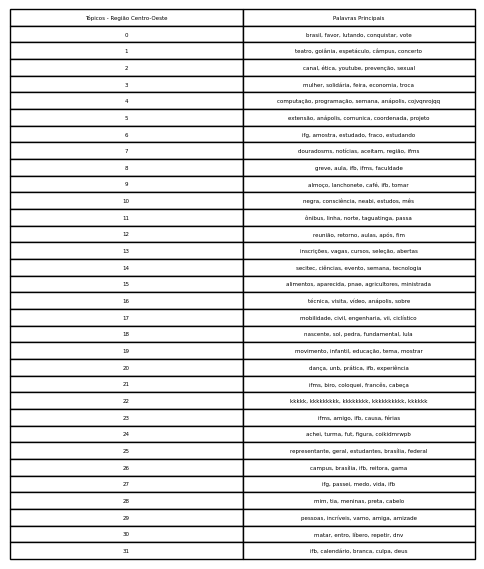

In [32]:
# Criar a tabela
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis("tight")
ax.axis("off")
table = ax.table(cellText=df_topics.values, colLabels=df_topics.columns, cellLoc="center", loc="center")

# Salvar imagem
plt.savefig("tabela_topicos_centro_oeste.png", bbox_inches="tight", dpi=300)
plt.show()